<a href="https://colab.research.google.com/github/jgkorman/Statistical-Analysis-In-Python/blob/main/Assignment_2_PDLA_Korman_JamesG_ICPSR_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ICPSR PDLA Assignment 2**
Author: Korman, James, G



*Note, the assignment starts at the section titled: "Start of Homework 2 PLDA"*

Useful Links

1. https://timeseriesreasoning.com/contents/pooled-ols-regression-models-for-panel-data-sets/

2. https://towardsdatascience.com/a-guide-to-panel-data-regression-theoretics-and-implementation-with-python-4c84c5055cf8

3. https://bashtage.github.io/linearmodels/index.html

4. https://aeturrell.github.io/coding-for-economists/econmt-regression.html

5. https://eshinjolly.com/pymer4/


Cross Sectional Autocorrelation/Dependence Tests
1. Breusch-Pagan LM Test
2. Pesaran CD Test
3. Friedman Rave Test
4. Frees FRE Test


---

Temporal Autocorrelation Tests 
1. Wooldridge-Drukker test for temporal autocorrelation
2. Baltagi-Li test
3. Bhargava et al: modified Durbin-Watson with strange critical values
4. Baltagi-Wu LBI test: allows for missing data in the middle of the series
5. Inoue-Solon and Born-Breitung: allows for testing up to AR(p) processes,
can allow for heteroskedasticity


## **Reading in the Data & Descriptive Statistics**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import scipy.stats as st
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsap
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_white


In [2]:
dtafile = '/content/drive/MyDrive/Delaware/ICPSR_2022/Panel Data And Longitudinal Analysis/Assignments/Assignment 2_Topics 3 & 4/Copy of Poe and Tate APSR 1994.dta'

df = pd.read_stata(dtafile)
df

,ccode,year,vanhdemo,pcgnp,left,ainew,sdnew,milctr2,britinfl,lpop,iwar,cwar,popinc,pcginc,polrtnew,lag_ainew,lag_sdnew
0,2,1980,18.700001,11.347000,0,1,1,0,1,19.243561,0,0,1.008137,7.513738,7,NaN,NaN
1,2,1981,18.700001,12.253999,0,1,1,0,1,19.254190,0,0,1.008137,7.993301,7,1.0,1.0
2,2,1982,18.700001,13.160000,0,1,1,0,1,19.264490,0,0,1.008137,7.393504,7,1.0,1.0
3,2,1983,18.700001,14.172000,0,1,1,0,1,19.274239,0,0,1.008137,7.689969,7,1.0,1.0
4,2,1984,16.100000,15.541000,0,1,1,0,1,19.283649,0,0,1.008137,9.659893,7,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,990,1983,NaN,0.560000,0,1,1,0,1,11.982929,0,0,1.045530,0.000000,4,1.0,1.0
1220,990,1984,NaN,0.680000,0,1,1,0,1,11.989160,0,0,1.045530,21.428570,4,1.0,1.0
1221,990,1985,NaN,0.620000,0,1,1,0,1,12.001510,0,0,1.045530,-8.823528,4,1.0,1.0
1222,990,1986,NaN,0.560000,0,1,1,0,1,12.013699,0,0,1.045530,-9.677419,4,1.0,1.0


# **1. The Pooled Cross-Section Model** (unit levels and time structure) ie not setting them in the multi-index 

### **a. Building the Model** 

**1. Defining the X and Y Variables**

In [3]:
y_var_name = 'pcgnp'
X_var_names = ['lpop', 'popinc', 'left']

**2. Carve out the Y vector from the Panel Data**

In [4]:
pooled_y = df[y_var_name]


**3. Carve out the X matrix from the data panel:**

In [5]:
pooled_X = df[X_var_names]
pooled_X

,lpop,popinc,left
0,19.243561,1.008137,0
1,19.254190,1.008137,0
2,19.264490,1.008137,0
3,19.274239,1.008137,0
4,19.283649,1.008137,0
...,...,...,...
1219,11.982929,1.045530,0
1220,11.989160,1.045530,0
1221,12.001510,1.045530,0
1222,12.013699,1.045530,0


**4. Add the placeholder for the regression intercept. When the model is fitted, the coefficient of this variable is the regression model’s intercept β_0.**

In [6]:
pooled_X = sm.add_constant(pooled_X)
pooled_X

,const,lpop,popinc,left
0,1.0,19.243561,1.008137,0
1,1.0,19.254190,1.008137,0
2,1.0,19.264490,1.008137,0
3,1.0,19.274239,1.008137,0
4,1.0,19.283649,1.008137,0
...,...,...,...,...
1219,1.0,11.982929,1.045530,0
1220,1.0,11.989160,1.045530,0
1221,1.0,12.001510,1.045530,0
1222,1.0,12.013699,1.045530,0


**5. Build the OLS regression model:**

In [7]:
pooled_olsr_model = sm.OLS(endog=pooled_y, exog=pooled_X)
pooled_olsr_model

**6. Train the model on the (y, X) data set and fetch the training results:**

In [8]:
pooled_olsr_model_results = pooled_olsr_model.fit()

**7. Print the Training Summary**

In [9]:
print(pooled_olsr_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  pcgnp   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     17.34
Date:                Sun, 24 Jul 2022   Prob (F-statistic):           4.99e-11
Time:                        19:50:20   Log-Likelihood:                -3668.0
No. Observations:                1224   AIC:                             7344.
Df Residuals:                    1220   BIC:                             7364.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6468      1.166      4.842      0.0

### **b. Analyzing the Goodness of Fit**

1. Overall, we explained about 4% of the variation in pcgnp from the Adj R^2

### **c. Analyzing the residuals (errors)**

In [10]:
print(pooled_olsr_model_results.resid)

0        7.062879
1        7.970402
2        8.876912
3        9.889394
4       11.258859
          ...    
1219    -4.067482
1220    -3.947174
1221    -4.006564
1222    -4.065962
1223    -4.065562
Length: 1224, dtype: float64


In [11]:
# the mean value of the residual errors
print('Mean value of residual errors='+str(pooled_olsr_model_results.resid.mean()))

Mean value of residual errors=-7.430512269386669e-16


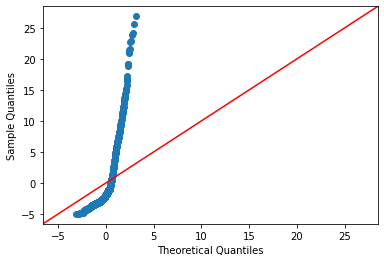

In [12]:
# analyzing the normality of the errors
sm.qqplot(data=pooled_olsr_model_results.resid, line='45')
plt.show()

Are data are in need of heavy transformation, the assumption of normality of the residuals in this context does not hold. Our Jarque_bera test in the model output also confirms this as it is greater than p < 0.001

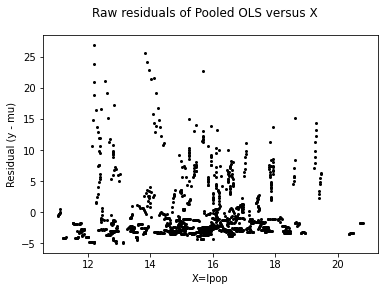

In [13]:
# analyzing heteroskeasticity 
fig, ax = plt.subplots()
fig.suptitle('Raw residuals of Pooled OLS versus X')
plt.ylabel('Residual (y - mu)')
plt.xlabel('X='+str(X_var_names[0]))
ax.scatter(pooled_X[X_var_names[0]], pooled_olsr_model_results.resid, s=4, c='black', label='Residual Error')
plt.show()

There appears to be a decent amount of heteroskedasticity in the model (alot). It is clear some obseratiosn are predicting pcgnp better than others. 

In [14]:
# The heteroskedasticity can be confirmed running the White test in which we will regress the square of the 
#residual on X and test the significance of resulting regression model’s coefficients as follows:

keys = ['Lagrange Multiplier statistic:', 'LM test\'s p-value:',
        'F-statistic:', 'F-test\'s ' 'p-value:']

results = het_white(resid=pooled_olsr_model_results.resid, exog=pooled_X)
 
print('Results of the White test for heteroskedasticity of residual errors ===> ')
 
print(lzip(keys,results))

Results of the White test for heteroskedasticity of residual errors ===> 
[('Lagrange Multiplier statistic:', 347.9447613982495), ("LM test's p-value:", 2.4863085751182453e-70), ('F-statistic:', 60.32052353422633), ("F-test's p-value:", 5.058558081682303e-83)]


The LM test’s p-value is < .001 indicating a rejection of the Null hypothesis of the White test that the residuals are homoskedastic

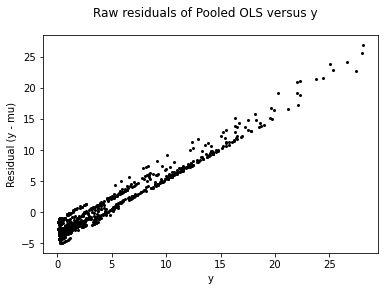

In [15]:
# Are the residual errors correlated w/ response variables Y?
fig, ax = plt.subplots()
fig.suptitle('Raw residuals of Pooled OLS versus y')
plt.ylabel('Residual (y - mu)')
plt.xlabel('y')
ax.scatter(pooled_y, pooled_olsr_model_results.resid, s=4, c='black', label='Residual Error')
plt.show()

There seems to be what looks like a linear trend between the residual errors and y. A correlation test using Pearson’s r confirms this visual judgement:

In [16]:
keys = ['Pearson\'s r:', 'p-value']
results = st.pearsonr(x=pooled_y, y=pooled_olsr_model_results.resid)
print('Results of the Pearson\'s r test of correlation between the residual errors and the response variable y ===>')
print(lzip(keys,results))

Results of the Pearson's r test of correlation between the residual errors and the response variable y ===>
[("Pearson's r:", 0.9793391954085706), ('p-value', 0.0)]


The high degree of correlation between the residual errors of regression and the response variable indicate that our Pooled OLSR model is missing important explanatory variables which would have otherwise been able to “explain” some of this correlation. Whatever variance in the per capita GDP growth rate (y) of the country that the gross capital formation rate (X) has not been able to explain has leaked into the residuals in the form of both a correlation with y, and heteroskedasticity

### **d. Analyzing autocorrelation**

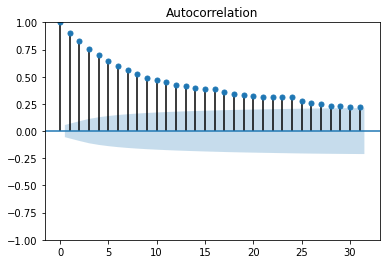

In [17]:
tsap.plot_acf(x=pooled_olsr_model_results.resid)
plt.show()

There is significant autocorrelation present atleast up to about 25 time periods suggesting to us our model is suffering from atocorrelation 

# **Start of Homework 2 PLDA**

# **2. The Pooled OLS Model** (Accounting for two dimensions (time and units) in the index 

## **Model 1**

In [18]:
# Import and preprocess data
import pandas as pd
!pip install linearmodels

dtafile = '/content/drive/MyDrive/Delaware/ICPSR_2022/Panel Data And Longitudinal Analysis/Assignments/Assignment 2_Topics 3 & 4/Copy of Poe and Tate APSR 1994.dta'


dataset = pd.read_stata(dtafile)
dataset = dataset.set_index(['ccode', 'year'])
dataset


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


vanhdemo      pcgnp  left  ainew  sdnew  milctr2  britinfl  \
ccode year                                                                
2     1980  18.700001  11.347000     0      1      1        0         1   
      1981  18.700001  12.253999     0      1      1        0         1   
      1982  18.700001  13.160000     0      1      1        0         1   
      1983  18.700001  14.172000     0      1      1        0         1   
      1984  16.100000  15.541000     0      1      1        0         1   
...               ...        ...   ...    ...    ...      ...       ...   
990   1983        NaN   0.560000     0      1      1        0         1   
      1984        NaN   0.680000     0      1      1        0         1   
      1985        NaN   0.620000     0      1      1        0         1   
      1986        NaN   0.560000     0      1      1        0         1   
      1987        NaN   0.560000     0      1      1        0         1   

                 lpop  iwar  cwar    popinc     pcginc  polrtnew  lag_ainew  \
ccode year                                                                    
2     1980  19.243561     0     0  1.008137   7.513738         7        NaN   
      1981  19.254190     0     0  1.008137   7.993301         7        1.0   
      1982  19.264490     0     0  1.008137   7.393504         7        1.0   
      1983  19.274239     0     0  1.008137   7.689969         7        1.0   
      1984  19.283649     0     0  1.008137   9.659893         7        1.0   
...               ...   ...   ...       ...        ...       ...        ...   
990   1983  11.982929     0     0  1.045530   0.000000         4        1.0   
      1984  11.989160     0     0  1.045530  21.428570         4        1.0   
      1985  12.001510     0     0  1.045530  -8.823528         4        1.0   
      1986  12.013699     0     0  1.045530  -9.677419         4        1.0   
      1987  12.021809     0     0  1.045530   0.000000         4        1.0   

            lag_sdnew  
ccode year             
2     1980        NaN  
      1981        1.0  
      1982        1.0  
      1983        1.0  
      1984        1.0  
...               ...  
990   1983        1.0  
      1984        1.0  
      1985        1.0  
      1986        1.0  
      1987        1.0  

[1224 rows x 15 columns]

In [19]:
years = dataset.index.get_level_values('year').to_list()
dataset['year'] = pd.Categorical(years)

# creating a lag of the Dependent Variable 'pcgnp'
dataset['lag_pcgnp'] = dataset['pcgnp'].shift(1)

dataset




vanhdemo      pcgnp  left  ainew  sdnew  milctr2  britinfl  \
ccode year                                                                
2     1980  18.700001  11.347000     0      1      1        0         1   
      1981  18.700001  12.253999     0      1      1        0         1   
      1982  18.700001  13.160000     0      1      1        0         1   
      1983  18.700001  14.172000     0      1      1        0         1   
      1984  16.100000  15.541000     0      1      1        0         1   
...               ...        ...   ...    ...    ...      ...       ...   
990   1983        NaN   0.560000     0      1      1        0         1   
      1984        NaN   0.680000     0      1      1        0         1   
      1985        NaN   0.620000     0      1      1        0         1   
      1986        NaN   0.560000     0      1      1        0         1   
      1987        NaN   0.560000     0      1      1        0         1   

                 lpop  iwar  cwar    popinc     pcginc  polrtnew  lag_ainew  \
ccode year                                                                    
2     1980  19.243561     0     0  1.008137   7.513738         7        NaN   
      1981  19.254190     0     0  1.008137   7.993301         7        1.0   
      1982  19.264490     0     0  1.008137   7.393504         7        1.0   
      1983  19.274239     0     0  1.008137   7.689969         7        1.0   
      1984  19.283649     0     0  1.008137   9.659893         7        1.0   
...               ...   ...   ...       ...        ...       ...        ...   
990   1983  11.982929     0     0  1.045530   0.000000         4        1.0   
      1984  11.989160     0     0  1.045530  21.428570         4        1.0   
      1985  12.001510     0     0  1.045530  -8.823528         4        1.0   
      1986  12.013699     0     0  1.045530  -9.677419         4        1.0   
      1987  12.021809     0     0  1.045530   0.000000         4        1.0   

            lag_sdnew  year  lag_pcgnp  
ccode year                              
2     1980        NaN  1980        NaN  
      1981        1.0  1981  11.347000  
      1982        1.0  1982  12.253999  
      1983        1.0  1983  13.160000  
      1984        1.0  1984  14.172000  
...               ...   ...        ...  
990   1983        1.0  1983   0.560000  
      1984        1.0  1984   0.560000  
      1985        1.0  1985   0.680000  
      1986        1.0  1986   0.620000  
      1987        1.0  1987   0.560000  

[1224 rows x 17 columns]

In [20]:
# Perform PooledOLS
from linearmodels import PooledOLS
import statsmodels.api as sm

exog = dataset[['lpop', 'popinc', 'left']]
exog = sm.tools.tools.add_constant(exog)
endog = dataset['pcgnp']
mod = PooledOLS(endog, exog)
pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)

#Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids

In [21]:
pooledOLS_res

Dep. Variable:,pcgnp,R-squared:,0.0409
Estimator:,PooledOLS,R-squared (Between):,0.0433
No. Observations:,1224,R-squared (Within):,-0.0034
Date:,"Sun, Jul 24 2022",R-squared (Overall):,0.0409
Time:,19:50:26,Log-likelihood,-3668.0
Cov. Estimator:,Clustered,,
,,F-statistic:,17.340
Entities:,153,P-value,0.0000
Avg Obs:,8.0000,Distribution:,"F(3,1220)"
Min Obs:,8.0000,,
Max Obs:,8.0000,F-statistic (robust):,3.4298


## **a. Examnining both temporal and spatial autocorrelation (checking for heteroskedasticity & autocorrelation**

### **i. Homoskedasticity check**

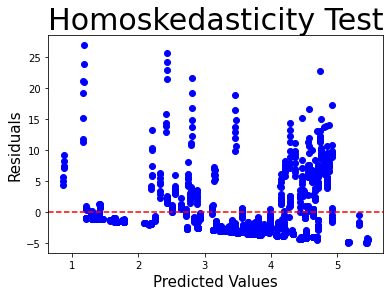

In [22]:
# 3A. Homoskedasticity
import matplotlib.pyplot as plt
 # 3A.1 Residuals-Plot for growing Variance Detection
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 15)
ax.set_ylabel('Residuals', fontsize = 15)
ax.set_title('Homoskedasticity Test', fontsize = 30)
plt.show()

Some values are systematically predicting values of pcgnp better than others and the errors are not homoskedastic (ie constant variance). We will confirm with a White Test & a Breusch-Pagan LM Test 

In [23]:
# 3A.2 White-Test
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
pooled_OLS_dataset = pd.concat([dataset, residuals_pooled_OLS], axis=1)
pooled_OLS_dataset = pooled_OLS_dataset.drop(['year'], axis = 1).fillna(0)
exog = dataset[['lpop', 'popinc', 'left']]
exog = sm.tools.tools.add_constant(exog).fillna(0)


white_test_results = het_white(pooled_OLS_dataset['residual'], exog)

labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, white_test_results)))

# 3A.3 Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, breusch_pagan_test_results)))

{'LM-Stat': 347.9447613982496, 'LM p-val': 2.486308575118104e-70, 'F-Stat': 60.32052353422635, 'F p-val': 5.058558081682303e-83}
{'LM-Stat': 68.86950731283335, 'LM p-val': 7.452537399189447e-15, 'F-Stat': 24.245687522916473, 'F p-val': 3.0522996703489514e-15}


### **ii. Autocorrelation Check**

In [24]:
# 3.B Non-Autocorrelation
# Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson

durbin_watson_test_results = durbin_watson(pooled_OLS_dataset['residual']) 
print(durbin_watson_test_results)

0.1961635401917736


## **Model 2**

**Pooled OLS w/ Clustered Standard Errors controlling for spatio-temporal autocorrelation**

In [25]:
clust_entity_time = mod.fit(
    cov_type="clustered", cluster_entity=True, cluster_time=True
)

#Store values for checking homoskedasticity graphically
fittedvals_clust_entity_time = clust_entity_time.predict().fitted_values
residuals_clust_entity_time = clust_entity_time.resids

clust_entity_time

Dep. Variable:,pcgnp,R-squared:,0.0409
Estimator:,PooledOLS,R-squared (Between):,0.0433
No. Observations:,1224,R-squared (Within):,-0.0034
Date:,"Sun, Jul 24 2022",R-squared (Overall):,0.0409
Time:,19:50:26,Log-likelihood,-3668.0
Cov. Estimator:,Clustered,,
,,F-statistic:,17.340
Entities:,153,P-value,0.0000
Avg Obs:,8.0000,Distribution:,"F(3,1220)"
Min Obs:,8.0000,,
Max Obs:,8.0000,F-statistic (robust):,3.7786


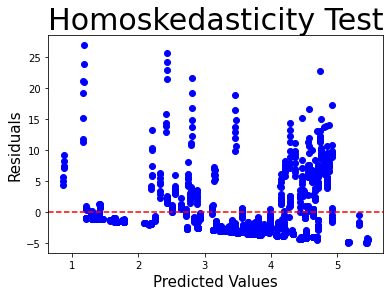

In [26]:
# 3A. Homoskedasticity
import matplotlib.pyplot as plt
 # 3A.1 Residuals-Plot for growing Variance Detection
fig, ax = plt.subplots()
ax.scatter(fittedvals_clust_entity_time, residuals_clust_entity_time, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 15)
ax.set_ylabel('Residuals', fontsize = 15)
ax.set_title('Homoskedasticity Test', fontsize = 30)
plt.show()

In [27]:
# 3A.2 White-Test
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
pooled_OLS_dataset_ent_time = pd.concat([dataset, residuals_clust_entity_time], axis=1)
pooled_OLS_dataset_ent_time = pooled_OLS_dataset_ent_time.drop(['year'], axis = 1).fillna(0)
exog = dataset[['lpop', 'popinc', 'left']]
exog = sm.tools.tools.add_constant(exog).fillna(0)


white_test_results_ent_time = het_white(pooled_OLS_dataset_ent_time['residual'], exog)

labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, white_test_results_ent_time)))

# 3A.3 Breusch-Pagan-Test
breusch_pagan_test_results_ent_time = het_breuschpagan(pooled_OLS_dataset_ent_time['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, breusch_pagan_test_results_ent_time)))

{'LM-Stat': 347.9447613982496, 'LM p-val': 2.486308575118104e-70, 'F-Stat': 60.32052353422635, 'F p-val': 5.058558081682303e-83}
{'LM-Stat': 68.86950731283335, 'LM p-val': 7.452537399189447e-15, 'F-Stat': 24.245687522916473, 'F p-val': 3.0522996703489514e-15}


In [28]:
# 3.B Non-Autocorrelation
# Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson

durbin_watson_test_results_ent_time = durbin_watson(pooled_OLS_dataset_ent_time['residual']) 
print(durbin_watson_test_results_ent_time)

0.1961635401917736


The durbin watson t-stat is showing a value of 0.19 which implies a very strong positive autocorrelation given the statistic ranges from 0-4 where as 2 implies no autocorrelation and 0-2 implies positive autocorrelation whereas 2-4 posits negative autocorrelation -- this suggests to us in this context that a fixed and or a random effects model may be more suitable in this context to control for the unobserved heterogeneity's that are being thrown into the error term

## **Model 3**

### **Estimating a Final model with entity/time clustered SE's & a lagged DV**

In [29]:
# Perform PooledOLS
from linearmodels import PooledOLS
import statsmodels.api as sm

exog = dataset[['lpop', 'popinc', 'left', 'lag_pcgnp']]
exog = sm.tools.tools.add_constant(exog)
endog = dataset['pcgnp']
mod = PooledOLS(endog, exog)
pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)

#Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids

/usr/local/lib/python3.7/dist-packages/linearmodels/shared/exceptions.py:37: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [30]:
pooledOLS_res

Dep. Variable:,pcgnp,R-squared:,0.8225
Estimator:,PooledOLS,R-squared (Between):,0.9663
No. Observations:,1223,R-squared (Within):,-1.8373
Date:,"Sun, Jul 24 2022",R-squared (Overall):,0.8225
Time:,19:50:27,Log-likelihood,-2632.8
Cov. Estimator:,Clustered,,
,,F-statistic:,1410.6
Entities:,153,P-value,0.0000
Avg Obs:,7.9935,Distribution:,"F(4,1218)"
Min Obs:,7.0000,,
Max Obs:,8.0000,F-statistic (robust):,632.89


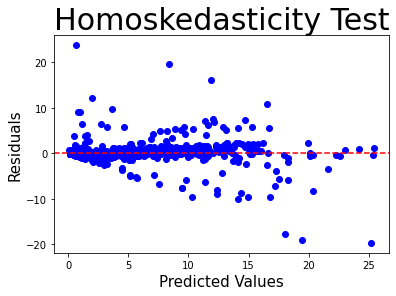

In [31]:
# 3A. Homoskedasticity
import matplotlib.pyplot as plt
 # 3A.1 Residuals-Plot for growing Variance Detection
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 15)
ax.set_ylabel('Residuals', fontsize = 15)
ax.set_title('Homoskedasticity Test', fontsize = 30)
plt.show()

In [32]:
# 3A.2 White-Test
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
pooled_OLS_dataset = pd.concat([dataset, residuals_pooled_OLS], axis=1)
pooled_OLS_dataset = pooled_OLS_dataset.drop(['year'], axis = 1).fillna(0)
exog = dataset[['lpop', 'popinc', 'left', 'lag_pcgnp']]
exog = sm.tools.tools.add_constant(exog).fillna(0)


white_test_results = het_white(pooled_OLS_dataset['residual'], exog)

labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, white_test_results)))

# 3A.3 Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, breusch_pagan_test_results)))

{'LM-Stat': 155.85278479680233, 'LM p-val': 1.3595306135794847e-26, 'F-Stat': 13.580803708875113, 'F p-val': 1.48583902515674e-28}
{'LM-Stat': 81.50284099211092, 'LM p-val': 8.36670014971006e-17, 'F-Stat': 21.740089764349506, 'F p-val': 2.3925612173811842e-17}


Overall, it appears that our model is still suffering from spatio-dependence after including a lagged AR(1) of the Dependent Variable on the right-hand side of the regression equation but the heteroskeadasticity has been improve and our variance is much more homoskedastic

In [33]:
# 3.B Non-Autocorrelation
# Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson

durbin_watson_test_results = durbin_watson(pooled_OLS_dataset['residual']) 
print(durbin_watson_test_results)

2.1717206733872105


However, after including a lag of the DV on the right-hand side of the model, our temporal autocorrelation has greatly been accounted for as is evident by the DW test statistic hovering near 2 which suggests to us very low levels of temporal autocorrelation or possibly slighlty negative autocorrelation but nothing of which is too concerning. 

# **Question 1**
"Using the model specification used in PCSEs.do, test for cross sectional dependence and autocorrelation. Remember that you need to run xtreg before using some of the dependence tests (e.g., xtreg vanhdemo pcgnp left lpop iwar milctr2 britinfl). Report your results; do you find evidence of temporal dependence? Cross-sectional dependence?"

## **Question 1 Answer:**

Overall, I have found in the first 2 models I estimated evidence of both temporal dependence and spatio-dependence. The Breusch-Pagan lm tests for both pooledOLS models reported (1. with clustered standard errors clustered solely by entity (controlling for autocorrelation across time), & 2. w/ clustered standard errors reported clustered by both time and entity (controlling for autocorrelation between entities w/in a given time period and across time respectively) showed a p value < 0.05 for both models implying that we have spatio-dependence. The White's test also confirmed this spatio-temporal finding along with graphical displays of the fitted values plotted against the residuals which showed clear heteroskedasticity as well. Also, I found robust evidence for autocorrelation as well from the Durbin-Watson test statistic calculated that showed for both models a DW test stat of roughly 0.19 suggesting to us very strong positive-autocorrelation. 

# **Question 2**
"Given the type of structure this panel data has (N x T), which test do you think might be the most reliable to use?"

## **Question 2 Answer**

In [34]:

print(f"Unique # of units (groups) = {len(pooled_OLS_dataset.index.get_level_values('ccode').unique())}")
print(f"Unique # of time periods = {len(pooled_OLS_dataset.index.get_level_values('year').unique())}")

Unique # of units (groups) = 153
Unique # of time periods = 8


Because N in this case is much much laarger than T -- it would be optimal if we could use the Freese, Friedman, or Pesaran tests for spatio dependence but given the limitations in python as a statistical software, I had to opt for the bruesch-pagan test along with white's test. For testing for autocorrelation, the durbin-watson test was employed once again due to the limitations in python statistical software. 



# **Question 3**
"Based on your results in Q1, estimate a model that accounts for the issues you describe above. Unfortunately, we can’t run these tests again after using xtpcse. But do your regression results change?"

### **Question 3 Answer**

Based on the results in Q1, the model I've estimated that accounts for the issues I described above is the model as was estimated in model 3 with clustered standard errors reported for both entity and time controlling for spatio dependence and temporal dependence respectively along with a lagged version of the dependent variable taking the form of an AR(1) included on the right-hand side of the regression equation. This accounts for the temporal autocorrelation while the spatio correlation is accounted for in the fixes with the standard errors clustered reported, although we can completely remove all bias from spatio-dependence and heterskedasticity, the estimate is still robust and the results remain consistent. However, the fact that we are still suffering from spatio-correlation as was evidenced by the Bruesch-Pagan test may also imply that there is still unobserved heterogeniety that is being picked up in the error term that is not being accounted for in the model which suggests to us that a fixed and or random effects model may also be a valid approach. 